<a href="https://colab.research.google.com/github/BoscoDomingo/ML-P1/blob/main/Bosco_Domingo%2C_Luis_de_Marcos_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main program

## Imports and global variables

In [204]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn import compose
from matplotlib import pyplot as plt

data_url = "https://raw.githubusercontent.com/BoscoDomingo/ML-P1/main/data/"
csv_filenames = ["audi.csv","bmw.csv", "cclass.csv", "focus.csv", "ford.csv" , "hyundi.csv", "merc.csv", "skoda.csv", "toyota.csv", "vauxhall.csv", "vw.csv"]
# There is no elegant solution to this yet. Google and Microsoft, pls.

## Carga de datos

In [205]:
df = pd.DataFrame(columns=["brand"])
for file in csv_filenames:
    partial_df = pd.read_csv(f"{data_url}{file}")
    if "tax(£)" in partial_df:
        partial_df.rename(columns={"tax(£)":"tax"}, inplace=True)
    partial_df["brand"] = file.split(".")[0]
    df = pd.concat([df, partial_df])
df.infer_objects()
df.year = pd.to_numeric(df.year, downcast='unsigned')

## Análisis de Datos y Preprocesamiento
Analizamos el DataFrame resultante de unificar los datos

In [206]:
df_backup = df.copy() # Backup so as not to have to re-read CSVs all the time

In [207]:
df = df_backup.copy()

In [208]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,108540.000000,108540.000000,108540.000000,99187.000000,99187.000000,108540.000000
mean,2017.098028,16890.124046,23025.928469,120.299838,55.166825,1.661644
std,2.130057,9756.266820,21176.423684,63.150926,16.138522,0.557058
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10229.500000,7491.750000,125.000000,47.100000,1.200000
50%,2017.000000,14698.000000,17265.000000,145.000000,54.300000,1.600000
75%,2019.000000,20940.000000,32236.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


In [209]:
df.columns

Index(['brand', 'model', 'year', 'price', 'transmission', 'mileage',
       'fuelType', 'tax', 'mpg', 'engineSize'],
      dtype='object')

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


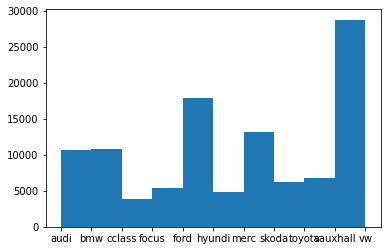

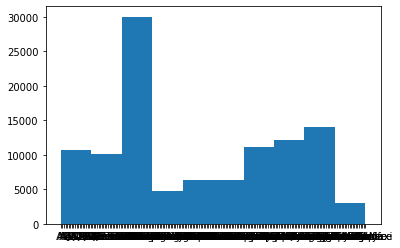

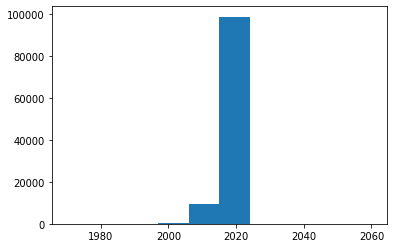

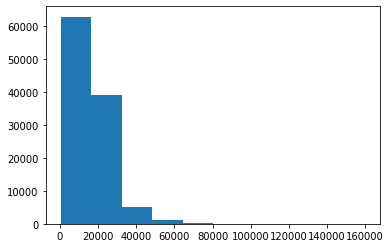

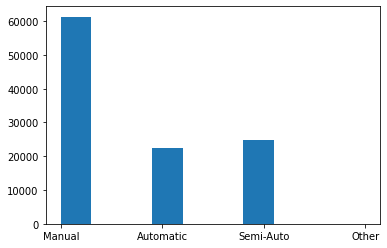

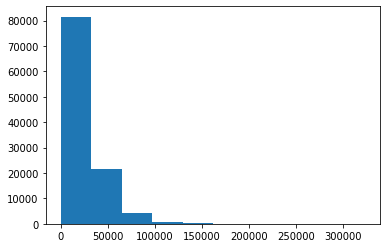

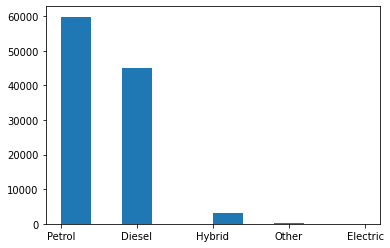

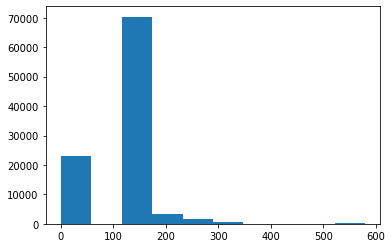

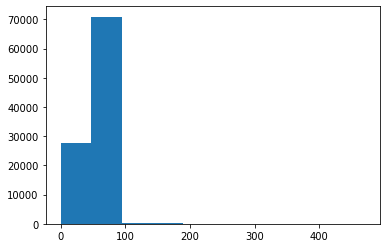

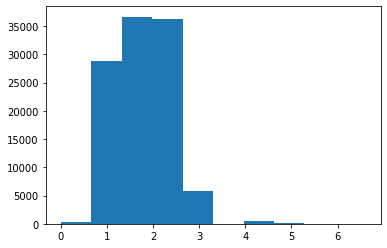

In [210]:
for i in df.columns:
    plt.figure()
    plt.hist(df[i])

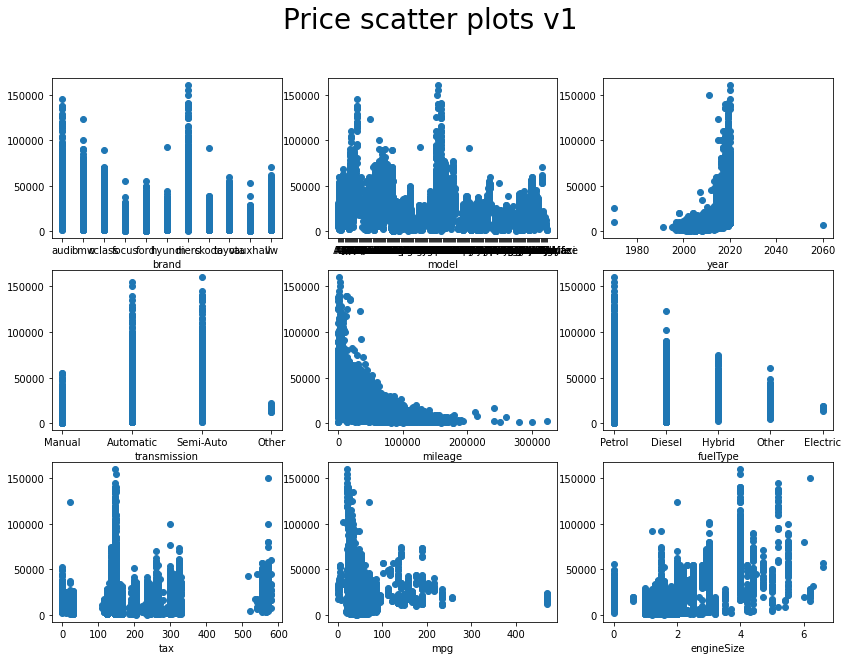

In [211]:
index = 1
plt.figure(figsize=(14,10))
plt.suptitle('Price scatter plots v1', size = 28);
for column in df.columns:
    if column == "price":
        continue
    plt.subplot(3,3,index)
    plt.scatter(df[column], df['price'])
    plt.xlabel(column)
    index += 1

# Source: https://datascience.stackexchange.com/a/31755

#### Anomalías observadas

*   Las columnas `tax` y `tax(£)` (que unificamos en el proceso de lectura) 
*   `year` superiores a 2020 (imposible)
*   `engineSize` con valor 0 (imposible)
*   `mpg` con valores imposibles (menores a 11 MPG o superiores a 94 MPG)
*   `mileage` con valores extremadamente altos y bajos



#### Filtrado inicial


1.   Eliminar filas con valores en `year` superiores a 2020 (que son imposibles)
2.   Eliminar filas con valores en `engineSize` menores que 1 (no existen coches con tamaño menor a 1L)
3.   Eliminar anomalías en `mpg` y `mileage` tomando sólo las filas que caigan dentro de µ ± 2σ (asumiendo una distribución normal esto sería el 95% de los casos en torno a la media)





In [212]:
# Filtering year
df = df[df["year"] <= 2020]

In [213]:
# Filtering engineSize
df = df[df["engineSize"] >= 0.5]

In [214]:
# Reducing sample size by mpg and mileage
df = df[(df.mpg > df.mpg.quantile(.025)) & (df.mpg < df.mpg.quantile(.975)) & (df.mileage > df.mileage.quantile(.025)) & (df.mileage < df.mileage.quantile(.975))]

##### Resultados tras las primeras operaciones

In [215]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,88857.000000,88857.000000,88857.000000,88857.000000,88857.000000,88857.000000
mean,2017.125302,16244.160584,21875.298277,119.775201,54.664647,1.631353
std,1.867092,8470.187435,17091.136569,58.654607,10.028370,0.507121
min,1970.000000,795.000000,101.000000,0.000000,32.900000,1.000000
25%,2016.000000,10000.000000,8234.000000,125.000000,47.100000,1.200000
50%,2017.000000,14249.000000,17766.000000,145.000000,54.300000,1.500000
75%,2019.000000,20000.000000,31524.000000,145.000000,61.700000,2.000000
max,2020.000000,123456.000000,79011.000000,330.000000,78.000000,5.000000


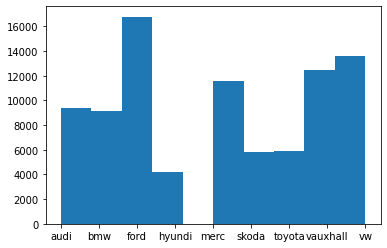

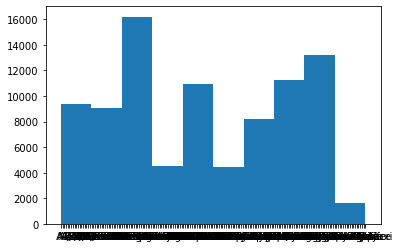

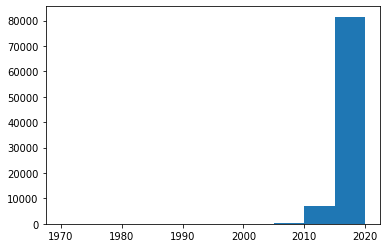

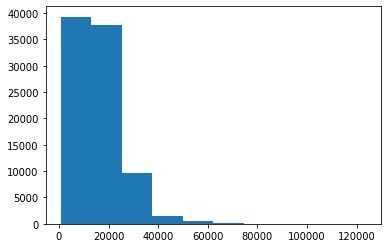

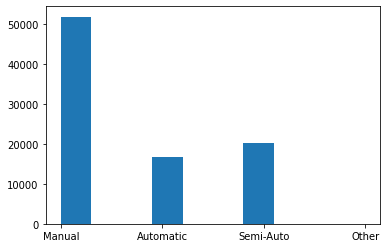

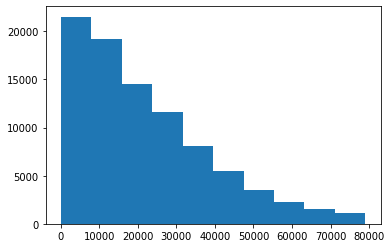

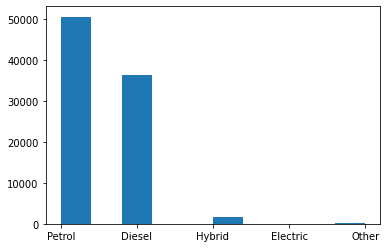

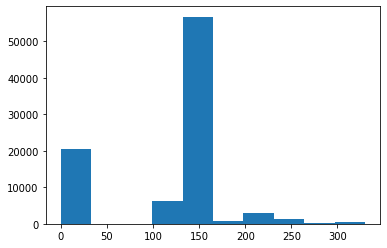

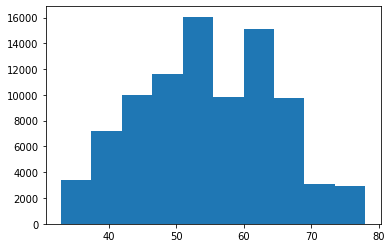

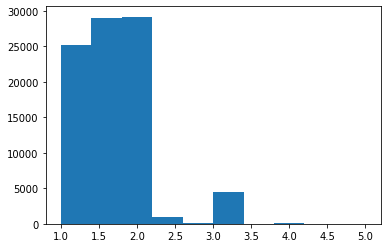

In [216]:
for i in df.columns:
    plt.figure()
    plt.hist(df[i])

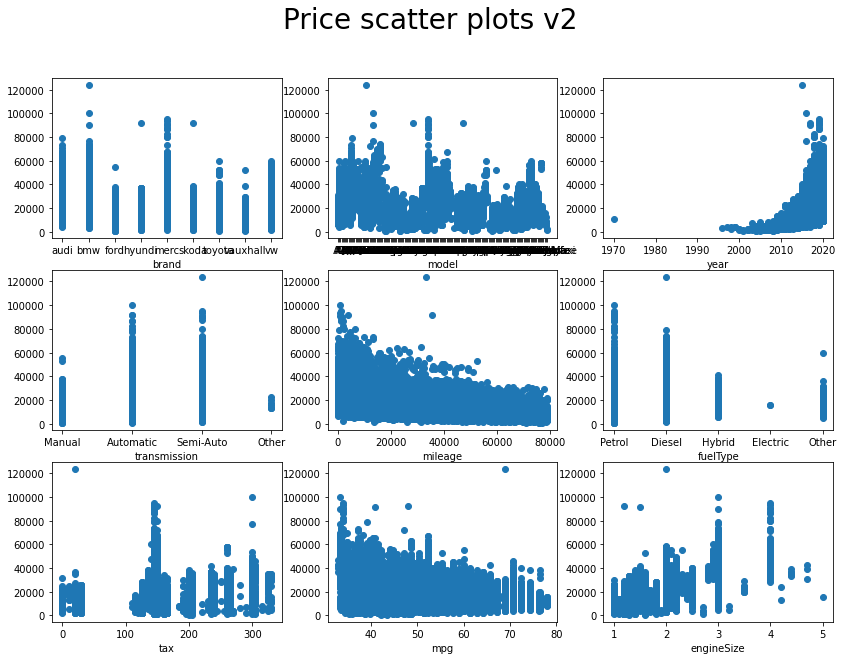

In [217]:
index = 1
plt.figure(figsize=(14,10))
plt.suptitle('Price scatter plots v2', size = 28);
for column in df.columns:
    if column == "price":
        continue
    plt.subplot(3,3,index)
    plt.scatter(df[column], df['price'])
    plt.xlabel(column)
    index += 1

# Source: https://datascience.stackexchange.com/a/31755

### Filtrado secundario
Tras ver los histogramas, decidimos eliminar features que no aportan un gran número de filas para el incremento en complejidad o que pueden ser posibles anomalías y afectar al entrenamiento:


*   List item
*   List item



### Reescalado

In [218]:
# Reescalar year, engineSize y luego estandarizamos si la distribución es normal, normalizamos si no

### One-Hot Encoding
*One-Hot Encoder* a las clases `brand`, `model`, `transmission`, `fuelType`

In [219]:
# One-Hot Encoder
for column_name, prefix in {"brand":"", "model":"model", "transmission": "gearbox", "fuelType":"fuel"}.items():
    if prefix:
        df = pd.concat([df, pd.get_dummies(df[column_name], prefix=prefix)], axis=1)
    else:
        df = pd.concat([df, pd.get_dummies(df[column_name])], axis=1)
    df.drop([column_name], axis=1, inplace=True)

# Testing

In [220]:
df = df_backup.copy()
df

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,audi,A1,2017,12500.0,Manual,15735.0,Petrol,150.0,55.4,1.4
1,audi,A6,2016,16500.0,Automatic,36203.0,Diesel,20.0,64.2,2.0
2,audi,A1,2016,11000.0,Manual,29946.0,Petrol,30.0,55.4,1.4
3,audi,A4,2017,16800.0,Automatic,25952.0,Diesel,145.0,67.3,2.0
4,audi,A3,2019,17300.0,Manual,1998.0,Petrol,145.0,49.6,1.0
...,...,...,...,...,...,...,...,...,...,...
15152,vw,Eos,2012,5990.0,Manual,74000.0,Diesel,125.0,58.9,2.0
15153,vw,Fox,2008,1799.0,Manual,88102.0,Petrol,145.0,46.3,1.2
15154,vw,Fox,2009,1590.0,Manual,70000.0,Petrol,200.0,42.0,1.4
15155,vw,Fox,2006,1250.0,Manual,82704.0,Petrol,150.0,46.3,1.2


In [221]:
df.brand.nunique() # should be 11

11

In [222]:
df.fuelType.describe()

count     108540
unique         5
top       Petrol
freq       59875
Name: fuelType, dtype: object

In [223]:
df.transmission.describe()

count     108540
unique         4
top       Manual
freq       61308
Name: transmission, dtype: object

In [224]:
df.transmission.unique()

array(['Manual', 'Automatic', 'Semi-Auto', 'Other'], dtype=object)

In [225]:
df.fuelType.unique()

array(['Petrol', 'Diesel', 'Hybrid', 'Other', 'Electric'], dtype=object)

In [226]:
print(sorted(df.year.unique())) # To detect the anomaly

[1970, 1991, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2060]


In [ ]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba985ac1d0>,
      dtype=object)

In [ ]:
column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("scale", sklearn.preprocessing.StandardScaler(), [0]),
    ("passthrough", "passthrough", [1]),
    ("scale", sklearn.preprocessing.StandardScaler(), [2]),
    ("min-max", sklearn.preprocessing.MinMaxScaler(), [3]),
    ("one-hot", sklearn.preprocessing.OneHotEncoder(), [4])
]);

In [ ]:
sigma = df.describe().loc['std'][0]
mean = df.describe().loc['mean'][0]
df[(df["mpg"] > mean - 2*sigma) & (df["mpg"] < mean + 2*sigma)].describe() # Doesn't work

In [ ]:
df[(df.mpg > df.mpg.quantile(.025)) & (df.mpg < df.mpg.quantile(.975))].describe()

In [ ]:
df[df["mpg"] == 11].head()

In [ ]:
df[(df["mpg"] > 11) & (df["mpg"] <= 94)].describe()

In [ ]:
df[df["mileage"] > 250000].head()

In [ ]:
df[(df.tax >= df.tax.quantile(.003)) & (df.tax <= df.tax.quantile(.997))].describe() # Esto se puede hacer así, tenemos que poner el 1-.997 también...?

In [ ]:
print(sorted(df.engineSize.unique()))

In [ ]:
import seaborn as sns
sns.pairplot(data=df,y_vars=['price'],x_vars=df.columns)
# Source: https://stackoverflow.com/a/43322569/9022642

# References

1.   https://www.inchcape.co.uk/blog/guides/what-size-engine-do-i-need/
2.   https://motorway.co.uk/guides/best-cars-for-mpg
3.   https://www.caranddriver.com/features/g30256394/worst-fuel-economy-cars/?slide=1

